# Dataset loading tools

In [2]:
import pycocotools.mask as mask_coco
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
import json


class WildlifeDataset():
    '''
    PyTorch-style dataset for a wildlife image classification task.

    Args:
        df: A pandas dataframe containing image metadata.
        root: Root directory for images.
        transform: A function/transform that takes in an image and returns a transformed version.
        img_load: Method to load images. Valid options are 'full', 'full_mask', 'full_hide', 'bbox', 'bbox_mask', 'bbox_hide', and 'crop_black'.
        col_path: Column name in the dataframe containing image file paths.
        col_identity: Column name in the dataframe containing class labels.

    Attributes:
        label: An array of integer labels for all images in the dataset.
        label_map: A mapping between integer label and string label.
            
    Methods:
        get_image(path): Load an image from file and convert it to a PIL Image object.
        
    Properties:
        num_classes: Return the number of unique classes in the dataset.
        __len__: Return the number of samples in the dataset.
        __getitem__(idx): Return (sample, label) tuple. Get a sample from the dataset at a given index.
    '''

    def __init__(self, df, root='.', transform=None, img_load='full', col_path='path', col_identity='identity'):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.transform = transform
        self.img_load = img_load
        self.label, self.label_map = pd.factorize(df[col_identity].values)
        self.col_path = col_path

    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        return img

    @property
    def num_classes(self):
        return len(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        img = self.get_image(os.path.join(self.root, data[self.col_path]))
        
        if (self.img_load in ['full_mask', 'full_hide', 'bbox_mask', 'bbox_hide']) and ('segmentation' in data):
            if type(data['segmentation']) == str:
                segmentation = eval(data['segmentation'])
            else:
                segmentation = data['segmentation']

        if ('bbox' in self.img_load) and ('bbox' in data):
            if type(data['bbox']) == str:
                bbox = json.loads(data['bbox'])
            else:
                bbox = data['bbox']

        # Load full image as it is.
        if self.img_load == 'full':
            img = img

        # Mask background using segmentation mask.
        elif self.img_load == 'full_mask':
            mask = mask_coco.decode(segmentation).astype('bool')
            img = Image.fromarray(img * mask[..., np.newaxis])
        
        # Hide object using segmentation mask
        elif self.img_load == 'full_hide':
            mask = mask_coco.decode(segmentation).astype('bool')
            img = Image.fromarray(img * ~mask[..., np.newaxis])

        # Crop to bounding box
        elif self.img_load == 'bbox':
            img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))

        # Mask background using segmentation mask and crop to bounding box.
        elif self.img_load == 'bbox_mask':
            mask = mask_coco.decode(segmentation).astype('bool')
            img = Image.fromarray(img * mask[..., np.newaxis])
            img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))

        # Hide object using segmentation mask and crop to bounding box.
        elif self.img_load == 'bbox_hide':
            mask = mask_coco.decode(segmentation).astype('bool')
            img = Image.fromarray(img * ~mask[..., np.newaxis])
            img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))

        # Crop black background around images
        elif self.img_load == 'crop_black':
            y_nonzero, x_nonzero, _ = np.nonzero(img)
            img = img.crop((np.min(x_nonzero), np.min(y_nonzero), np.max(x_nonzero), np.max(y_nonzero)))

        else:
            raise ValueError(f'Invalid img_load argument: {self.img_load}')

        if self.transform:
            img = self.transform(img)
        return img, self.label[idx]


In [ ]:
class InMemoryDataset():
    def __init__(self, iterable, chunk, chunk_total=1, data_key=0):
        self.chunk = 1
        self.chunk_total = 1
        self.data_key = 0
        self.subset = np.array_split(np.arange(len(dataset)), chunk_total)[chunk-1]
        self.data = [data[data_key] for i, data in enumerate(dataset) if i in self.subset]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
class LocalFeaturesDataset():
    def __init__(self, iterable, chunk, chunk_total=1, data_key=0):
        with open(path, 'rb') as file:
            self.features = pickle.load(file)
        return features

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]



## 1. Load metadata

In [31]:
from wildlife_datasets.datasets import SeaTurtleID
root = '/mnt/data/turtles/datasets/datasets/SeaTurtleID'
metadata = SeaTurtleID(root).df
metadata.head()

,image_id,identity,path,split,bbox,date,orientation,segmentation
0,0,t281,images/t281/ILXxnZwvNh.JPG,train,"[769, 593, 135, 145]",2016-07-11 16:53:31,topleft,"{'size': [1333, 2000], 'counts': '[nZo034V1lW1..."
1,1,t281,images/t281/DjtwgIIURL.JPG,train,"[995, 466, 434, 302]",2016-07-11 16:53:13,right,"{'size': [1333, 2000], 'counts': 'jRaX1k1eW1<G..."
2,2,t281,images/t281/hHfmOdhzDU.JPG,train,"[669, 609, 163, 136]",2016-07-11 16:53:33,topleft,"{'size': [1333, 2000], 'counts': 'm`Wk0a0QY15M..."
3,3,t281,images/t281/gTovpgwOut.JPG,test,"[829, 476, 131, 99]",2016-07-11 16:54:03,left,"{'size': [1333, 2000], 'counts': '\nhQ1e0oX12N..."
4,4,t281,images/t281/yUETlrBYAp.JPG,train,"[940, 492, 534, 372]",2016-07-11 16:53:12,right,"{'size': [1333, 2000], 'counts': 'jWXV1T2]W1:F..."


## 2. Create WildlifeDataset
- By default, loads image in 'full' regime.

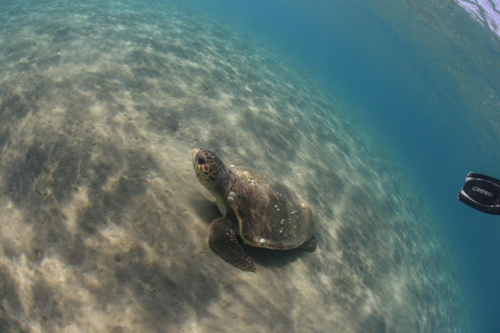

In [49]:
dataset = WildlifeDataset(metadata, root=root)
img, label = dataset[0]
img.resize((img.size[0] // 4, img.size[1] // 4))

## 3. Different load regimes

Full image
- Full image 'full'
- Full image with redacted background 'full_mask'
- Full image with redacted foreground 'full_hide'


BBox Cropping
- BBox cropped 'bbox'
- BBox cropped with redacted background 'bbox_mask'
- BBox cropped with redacted foreground 'bbox_hide'

Other
- Cropping black background if there is one 'crop_black'

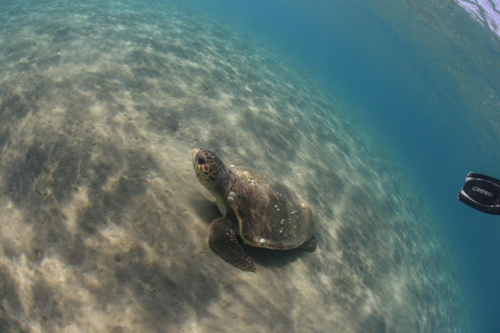

In [51]:
dataset = WildlifeDataset(metadata, root=root, img_load='full')
img, label = dataset[0]
img.resize((img.size[0] // 4, img.size[1] // 4))

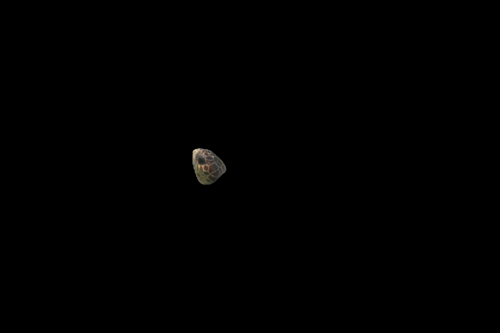

In [53]:
dataset = WildlifeDataset(metadata, root=root, img_load='full_mask')
img, label = dataset[0]
img.resize((img.size[0] // 4, img.size[1] // 4))

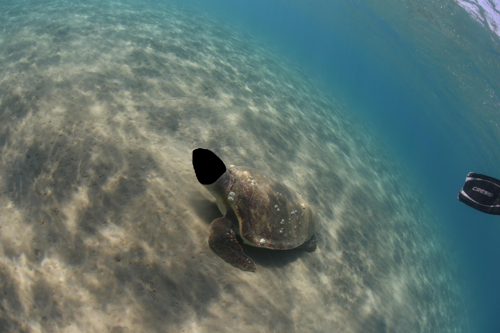

In [55]:
dataset = WildlifeDataset(metadata, root=root, img_load='full_hide')
img, label = dataset[0]
img.resize((img.size[0] // 4, img.size[1] // 4))

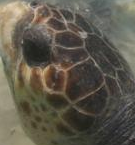

In [57]:
dataset = WildlifeDataset(metadata, root=root, img_load='bbox')
img, label = dataset[0]
img

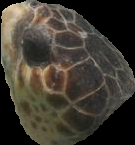

In [58]:
dataset = WildlifeDataset(metadata, root=root, img_load='bbox_mask')
img, label = dataset[0]
img

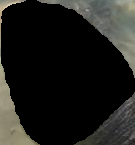

In [60]:
dataset = WildlifeDataset(metadata, root=root, img_load='bbox_hide')
img, label = dataset[0]
img

## 4. Add Transform pipeline

In [63]:
from torchvision import transforms as T
transform = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor(),
])
dataset = WildlifeDataset(metadata, root=root, img_load='full', transform=transform)
img, label = dataset[0]
print(img.shape)
img

torch.Size([3, 256, 256])


tensor([[[0.3020, 0.3059, 0.3059,  ..., 0.6627, 0.6784, 0.6627],
         [0.2980, 0.2941, 0.3020,  ..., 0.6431, 0.6745, 0.6667],
         [0.3098, 0.3098, 0.2980,  ..., 0.5922, 0.6471, 0.6627],
         ...,
         [0.2510, 0.2588, 0.2863,  ..., 0.1216, 0.1216, 0.1176],
         [0.2510, 0.2745, 0.2902,  ..., 0.1176, 0.1216, 0.1176],
         [0.2667, 0.3059, 0.3176,  ..., 0.1176, 0.1098, 0.1098]],

        [[0.4902, 0.4941, 0.4941,  ..., 0.6784, 0.6902, 0.6706],
         [0.4824, 0.4784, 0.4863,  ..., 0.6706, 0.6902, 0.6784],
         [0.4784, 0.4824, 0.4706,  ..., 0.6353, 0.6667, 0.6745],
         ...,
         [0.2706, 0.2784, 0.2941,  ..., 0.3176, 0.3137, 0.3059],
         [0.2784, 0.3020, 0.3020,  ..., 0.3176, 0.3098, 0.3059],
         [0.2863, 0.3176, 0.3216,  ..., 0.3176, 0.3098, 0.3098]],

        [[0.5059, 0.5098, 0.5098,  ..., 0.8706, 0.9098, 0.9020],
         [0.4980, 0.4980, 0.5020,  ..., 0.8314, 0.8824, 0.8980],
         [0.5020, 0.5020, 0.4941,  ..., 0.7608, 0.8314, 0.